In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

In [15]:
# %% 기준일과 매칭할 날짜 수 setting
daycount_match = 2 # 매칭할 대상 기간 : 2 days
daycount_forecast = 1 # 전망할 날짜 수 :  1 day
resample_minutes = 10 # 가격주기 : 10 mins

date_split = '2019-01-01'

In [16]:
# %% 1min 단위의 raw data 받아오기
df_infomax = pd.read_csv("../data/LKTB_infomax_1m.csv")
df_infomax['DATETIME'] = pd.to_datetime(df_infomax['DATE'] + ' ' + df_infomax['TIME'])
df = df_infomax.drop(['DATE', 'TIME'], axis=1)
df = df.set_index('DATETIME')

In [17]:
# %% resample
df = df.resample(str(resample_minutes) + 'T', closed='right').agg({
    'OPEN': 'first',
    'HIGH': 'max',
    'LOW': 'min',
    'CLOSE': 'last',
    'VOLUME': 'sum',
    'OPENINTEREST': 'last'
    }).dropna()

In [18]:
# In[14]: 날짜 list 만들기
list_day = df.resample('D') \
    .last() \
        .dropna() \
            .drop(['OPEN', 'HIGH', 'LOW', 'VOLUME','OPENINTEREST'], axis=1) \
                .reset_index()['DATETIME'] \
                    .dt.date \
                        .to_numpy().tolist()

In [26]:
# 매칭할 날짜 세팅
x_end_date = list_day[-1] # data중 마지막 날짜로 세팅하는 경우

# %% 날짜 list에서 패턴 매칭대상 start_date, end_date 가져오기
x_start_date = list_day[(list_day.index(x_end_date) - daycount_match + 1)].isoformat()

In [25]:
list_day[-1]

datetime.date(2020, 1, 8)

In [20]:
# %% df에서 패턴매칭대상 가격Moves 가져오기
np_moves_target = df.loc[x_start_date:x_end_date]['CLOSE'].to_numpy()
np_moves_target_z = stats.zscore(np_moves_target)

In [21]:
len(np_moves_target)

41

In [23]:
x_end_date

datetime.date(2020, 1, 8)

In [8]:
# %% data df를 days_matching 개수로 분리
list_start_date = []
list_end_date = []

for i in range(len(list_day)-daycount_match + 1):
    if list_day[i + daycount_match - 1] < x_end_date:
        list_start_date.append(list_day[i])
        list_end_date.append(list_day[i + daycount_match - 1])

In [9]:
# %% window 별 moves 분리
list_moves = []
for i in range(len(list_start_date)):
# for i in range(10):
    list_moves.append(df.loc[list_start_date[i].isoformat():list_end_date[i].isoformat()]['CLOSE'].to_numpy())


In [10]:
# %% dtw 구하기
list_dtw = []

from dtw import accelerated_dtw
from tqdm import tqdm

for np_moves_data in tqdm(list_moves):
    d, _, _, _ = accelerated_dtw(np_moves_target_z, stats.zscore(np_moves_data), 'euclidean')
    list_dtw.append(d)

100%|██████████| 2218/2218 [00:12<00:00, 175.49it/s]


In [11]:
# %% rank 구하기
list_rank = stats.rankdata(list_dtw).tolist()

# %% result dataframe 만들기
df_result = pd.DataFrame(list(zip(list_start_date, list_end_date, list_dtw, list_rank)),
                         columns = ['start', 'end', 'dtw', 'rank'])

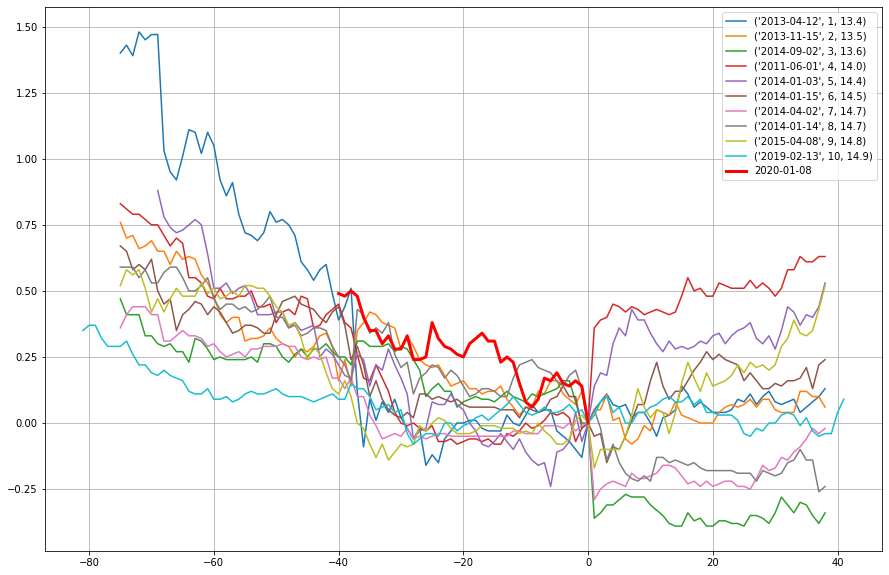

In [12]:
# %% rank 순서대로 plot
max_rank = 10

f1 = plt.figure(figsize=(15, 10))
plt.grid(b=True)

minutes_per_day = 405
points_per_day = math.ceil(minutes_per_day / resample_minutes)
points_before = points_per_day * daycount_match
points_after = points_per_day * daycount_forecast

x = np.linspace(-points_before + 1,points_after, points_before + points_after )

for rank in range(1,max_rank+1):
    index = list_rank.index(rank)
    dtw = list_dtw[index]
    moves_before = df.loc[list_start_date[index].isoformat():list_end_date[index].isoformat()]['CLOSE'].to_numpy()
    moves_after = df.loc[list_day[list_day.index(list_end_date[index]) + 1].isoformat():
                         list_day[min(list_day.index(list_end_date[index]) + daycount_forecast, len(list_day) - 1)].isoformat()]['CLOSE'].to_numpy()
    pivot_price = moves_before[-1]
    moves_before_scaled = moves_before - pivot_price
    moves_after_scaled = moves_after - pivot_price
    moves = np.concatenate((
        [np.nan]*(points_before - len(moves_before_scaled)),
        moves_before_scaled,
        moves_after_scaled,
        [np.nan]*(points_after - len(moves_after_scaled))
        ))
    plt.plot(x,moves,  label=(list_end_date[index].isoformat(),rank, round(dtw,1)))

# %%

# target moves plotting
pivot_price_target = np_moves_target[-1]
moves_target_before_scaled = np_moves_target - pivot_price_target
moves_target_after_scaled = []
moves_target_scaled = np.concatenate((
    [np.nan]*(points_before-len(moves_target_before_scaled)),
    moves_target_before_scaled,
    moves_target_after_scaled,
    [np.nan]*(points_after-len(moves_target_after_scaled))
    ))

plt.plot(x, moves_target_scaled,'r-', label=x_end_date, linewidth=3.0)
plt.legend(loc='best')
plt.show()

In [13]:
# %% df 2019와 이전으로 나누기
df_data = df[:date_split]
df_match = df[date_split:'2019-02-28']

# In[14]: 날짜 list 만들기
list_dates_data = df_data.resample('D') \
    .last() \
        .dropna() \
            .drop(['OPEN', 'HIGH', 'LOW', 'VOLUME', 'OPENINTEREST'], axis=1) \
                .reset_index()['DATETIME'] \
                    .dt.date \
                        .to_numpy().tolist()

list_dates_match = df_match.resample('D') \
    .last() \
        .dropna() \
            .drop(['OPEN', 'HIGH', 'LOW', 'VOLUME', 'OPENINTEREST'], axis=1) \
                .reset_index()['DATETIME'] \
                    .dt.date \
                        .to_numpy().tolist()

In [ ]:
# %%
list_data_date1 = []
list_data_date2 = []
list_data_date3 = []
list_data_date4 = []
for i in range(len(list_dates_data) - daycount_match - daycount_forecast + 1 ):
    list_data_date1.append(list_dates_data[i])
    list_data_date2.append(list_dates_data[i + daycount_match - 1] )
    list_data_date3.append(list_dates_data[i + daycount_match] )
    list_data_date4.append(list_dates_data[i + daycount_match + daycount_forecast - 1] )

list_match_date1 = []
list_match_date2 = []
list_match_date3 = []
list_match_date4 = []
for i in range(len(list_dates_match) - daycount_match - daycount_forecast + 1):
    list_match_date1.append(list_dates_match[i])
    list_match_date2.append(list_dates_match[i + daycount_match - 1])
    list_match_date3.append(list_dates_match[i + daycount_match] )
    list_match_date4.append(list_dates_match[i + daycount_match + daycount_forecast - 1] )


In [ ]:
# %% window 별 moves 분리
list_data_moves = []
list_match_moves = []
list_price_chg_actual = []
for i in range(len(list_data_date1)):
    list_data_moves.append(df_data.loc[list_data_date1[i].isoformat():list_data_date2[i].isoformat()]['CLOSE'].to_numpy())
for i in range(len(list_match_date1)):
    list_match_moves.append(df_match.loc[list_match_date1[i].isoformat():list_match_date2[i].isoformat()]['CLOSE'].to_numpy())
    list_price_chg_actual.append(df_match.loc[list_match_date4[i].isoformat()]['CLOSE'].to_numpy()[-1] - list_match_moves[i][-1])

In [ ]:
# %% for문 돌며 dtw 계산
#list_dtw = []

from dtw import accelerated_dtw
from tqdm import tqdm
max_rank = 20
list_price_chg_forecast = []

for np_moves_match in tqdm(list_match_moves): # match_moves의 각 하루치 일자 당 반복하며
    list_dtw = []
    price_chg_forecast = 0
    for np_moves_data in (list_data_moves):
        d, _, _, _ = accelerated_dtw(stats.zscore(np_moves_match), stats.zscore(np_moves_data), 'euclidean')
        list_dtw.append(d)
        list_rank = stats.rankdata(list_dtw).tolist()
    
    sum_chg_mult_weight = 0
    sum_weight = 0    
    for rank in range(1,max_rank+1):
        index = list_rank.index(rank)
        weight = 1/list_dtw[index]
        #date3 = list_data_date3[index]
        date4 = list_data_date4[index]
        pivot_price = list_data_moves[index][-1]
        close_price = df_data.loc[date4.isoformat()]['CLOSE'].to_numpy()[-1]
        price_chg = close_price - pivot_price
        sum_chg_mult_weight += price_chg * weight
        sum_weight += weight
    
    price_chg_forecast = sum_chg_mult_weight / sum_weight
    list_price_chg_forecast.append(price_chg_forecast)

In [ ]:
# %% result dataframe 만들기
df_result = pd.DataFrame(list(zip(list_match_date1,
                                  list_match_date2,
                                  list_match_date3,
                                  list_match_date4,
                                  list_price_chg_forecast,
                                  list_price_chg_actual)
                              ),
                         columns = ['date1', 'date2', 'date3', 'date4', 'forecast', 'actual'])

In [ ]:
df_result